##  Tensorflow을 이용한 FeedForward Network 구현하기

### _Objective_
1. Boston Dataset 을 이용해 집값을 예측하는 딥러닝 모델을 만들어 봅니다. 


In [0]:
# Boston Data set import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import load_boston

## DataSet 구성하기

In [17]:
boston = load_boston()

# show boston dataset
boston_df = pd.DataFrame(boston['data'],columns=boston['feature_names'])
boston_df['house_price'] = boston['target']

# normalization
mins = boston_df.min()
maxs = boston_df.max()
boston_df = (boston_df - mins) / (maxs - mins)
print('Data Shape : ', boston_df.shape)

# Input & Output Split
xs = boston_df.iloc[:, :13].values
ys = boston_df.iloc[:, -1].values.reshape([-1, 1])
print('X shape : {}, Y shape : {}'.format(xs.shape, ys.shape))

# 데이터 셋을 나누어 주세요. 
indices = np.asarray(range(len(xs))) # index
npr.shuffle(indices)

n_train = int(0.6 * len(indices))
n_test = len(indices) - n_train

train_indices , test_indices = np.split(indices, [n_train]) # indice를 n_train으로 나눔. 여기서는 전체 dataset이 2등분 된다.

train_xs = xs[train_indices]
train_ys = ys[train_indices]
test_xs = xs[test_indices]
test_ys = ys[test_indices]

Data Shape :  (506, 14)
X shape : (506, 13), Y shape : (506, 1)


## 문제 1. Boston 집값 예측 모델 구성하기

* Tensorflow 을 이용해 아래 Boston 집값을 예측하는 모델을 만들어 봅니다.<br>

** 구현 순서 **
1. ** 모델 생성** <br>
    - Weight의 초기화는 아래와 같습니다.<br>
       * 분포 형태 : 정규분포(Normal Distribution)
       * 평균과 표준편차 : (0, 0.1)

    - Bias의 초기화는 0으로 해줍니다.<br>

    - Activation Function은 모두 `relu`를 이용합니다.<br>

    - 모델의 층 구성은 아래와 같습니다.<br>
 
|layer|입력층|1번째 은닉층|2번째 은닉층|3번째 은닉층|출력층|
|---|---|---|---|---|---|
|shape|(None,13)|(None,64)|(None,128)|(None,256)|(None,1)|
 

2. **학습하기** <br>
 - 손실함수로는 `mean squared error`를 이용해 주세요.
 - Gradient Descent 알고리즘을 이용해 학습시킵니다. 아래의 코드를 이용해 주세요.
 
 ```python
 tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
 ```

 - 학습률은 0.1로 둡니다.(learning rate = 0.1)<br>
 - step 은 10000 번을 수행합니다.


3. **시각화 하기**<br>
 - train loss , test loss 을 시각화 해봅니다 .<br>
 - 예측이 정답과 얼마나 멀리 떨어져 있는지 파악하기 위해 정답값과 예측값을 하나의 plot에 시각화 합니다. <br>
 시각화 하는 방법은 <br>  scatter 의  x 축은 정답값 ys을 넣고,   scatter y 축은 모델의 예측값을 넣습니다.  
  $y=x$ 에서 벗어난 정도가 정답과 예측이 다른 정도 입니다.

#### 답안지 입력란
* 아래에 답을 서술하여 주세요.


In [0]:

graph = tf.Graph()
with graph.as_default() :
    with tf.name_scope('input_layer') :
        xs = tf.placeholder(tf.float64, shape=(None, 13), name='xs')
        ys = tf.placeholder(tf.float64, shape=(None, 1), name='ys')
        
    with tf.name_scope('1st_layer') :
        weights = tf.Variable(np.random.normal(size=(13, 64), loc=0.0, scale=0.1), dtype=tf.float64, name='weights')
        bias = tf.Variable(np.zeros(64), dtype=tf.float64, name='bias')
        logits = tf.matmul(xs, weights) + bias # xs.shape=(None, 13), weights.shape=(None, 64)
        layer1 = tf.nn.relu(logits, name='relu') # Activation Function은 모두 relu를 이용합니다. shape = (None, 64)

    with tf.name_scope('2nd_layer') : 
        weights = tf.Variable(np.random.normal(size=(64, 128), loc=0.0, scale=0.1), dtype=tf.float64, name='weights')
        bias = tf.Variable(np.zeros(128), dtype=tf.float64, name='bias')
        logits = tf.matmul(layer1, weights) + bias 
        layer2 = tf.nn.relu(logits, name='relu') 

    with tf.name_scope('3rd_layer') :
        weights = tf.Variable(np.random.normal(size=(128, 256), loc=0.0, scale=0.1), dtype=tf.float64, name='weights')
        bias = tf.Variable(np.zeros(256), dtype=tf.float64, name='bias')
        logits = tf.matmul(layer2, weights) + bias 
        layer3 = tf.nn.relu(logits, name='relu') 

    with tf.name_scope('output_layer') :
        weights = tf.Variable(np.random.normal(size=(256, 1), loc=0.0, scale=0.1), dtype=tf.float64, name='weights')
        bias = tf.Variable(np.zeros(1), dtype=tf.float64, name='bias')
        output = tf.matmul(layer3, weights) + bias 
        # 예측한 집값
        pred = tf.identity(output, name="pred")

    with tf.name_scope('loss') :
        # 손실함수로는 mean squared error를 이용해 주세요.
        mse = tf.reduce_mean(tf.sqrt((pred - ys)**2), axis=0) 
        tf.add_to_collection(tf.GraphKeys.LOSSES, mse)
    
    with tf.name_scope('train') :
        # Gradient Descent 알고리즘을 이용해 학습시킵니다.
        train_op = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(mse) 

In [19]:
#### Train ############################################################################
# tf.reset_default_graph()
with graph.as_default() :
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    model_dir = './week5/model_boston_train'
    
    loss_train_list = []
    pred_train_list = []
    epoc = 10000
    for i in tqdm(range(epoc)) :
        _, loss_, pred_= sess.run([train_op, mse, pred], feed_dict={xs : train_xs, ys : train_ys})    
        loss_train_list.append(loss_)
        pred_train_list.append(pred_)
        saver.save(sess, model_dir) # Todo : 매번 sess를 저장할 필요는 없다. 가장 loss가 적은 모델을 저장해야 한다.

100%|██████████| 10000/10000 [03:32<00:00, 47.08it/s]


In [20]:
##### Test ############################################################################
# tf.reset_default_graph()
with graph.as_default() :
    
    sess = tf.Session()
    saver = tf.train.import_meta_graph('./week5/model_boston_train.meta')  # 저장된 graph불러오기
    saver.restore(sess, './week5/model_boston_train')  
    # 저장해 놓은 변수의 값들을 graph의 초기화 값으로 넣어준다.  
    # model번호는 윗부분 코드에서 골라서 변수로 넘겨줘야 한다.
    
    xs = graph.get_tensor_by_name('input_layer/xs:0') # tensor이름은 :0
    ys = graph.get_tensor_by_name('input_layer/ys:0')
    pred = graph.get_tensor_by_name('output_layer/pred:0')
    loss = graph.get_collection(tf.GraphKeys.LOSSES)[0] # return type : list
    train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

    loss_test_list = []
    pred_test_list = []
    epoc = 10000
    for i in range(epoc) :
        _, loss_, pred_= sess.run([train_op, loss, pred], feed_dict={xs : test_xs, ys : test_ys})    
        loss_test_list.append(loss_)    
        pred_test_list.append(pred_)

INFO:tensorflow:Restoring parameters from ./week5/model_boston_train


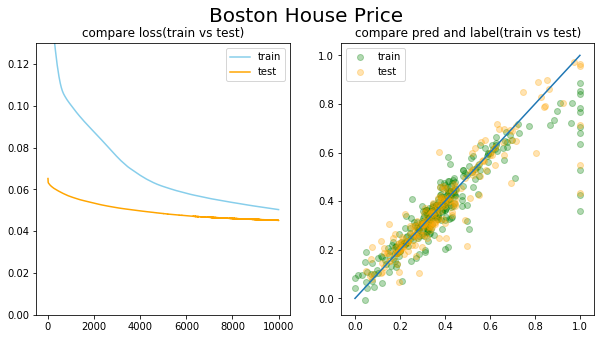

In [36]:
##### 시각화 ############################################################################
with graph.as_default() :
    
    fig = plt.figure(figsize=(10, 5))
    
    # train loss , test loss 을 시각화 해봅니다 .
    ax = fig.add_subplot(1,2,1)
    ax.set_title("compare loss(train vs test)", fontdict={'fontsize': 12})
    ax.plot(np.arange(0,epoc,1), loss_train_list, label="train", color='skyblue')
    ax.plot(np.arange(0,epoc,1), loss_test_list, label="test", color='orange')
    ax.set_label('loss')
    ax.set_ylim(0, 0.13)
    ax.legend()
    
    # 예측이 정답과 얼마나 멀리 떨어져 있는지 파악하기 위해 정답값과 예측값을 하나의 plot에 시각화 합니다. 
    # scatter 의 x 축은 정답값 ys을 넣고, scatter y 축은 모델의 예측값을 넣습니다.
    # y=x  에서 벗어난 정도가 정답과 예측이 다른 정도 입니다.        
    ax = fig.add_subplot(1,2,2)
    ax.set_title("compare pred and label(train vs test)", fontdict={'fontsize': 12})
    ax.scatter(train_ys, np.reshape(pred_train_list[-1], [-1]), label="train", color='green', alpha=0.3)
    ax.scatter(test_ys, np.reshape(pred_test_list[-1], [-1]), label="test", color='orange', alpha=0.3)
    ax.plot(np.linspace(0, 1.0, 100), np.linspace(0, 1.0, 100))
    ax.legend() 
    
    plt.suptitle("Boston House Price", fontsize =  20)
    plt.show()
    

#### 정답확인

* 아래와 같은 Loss 추이와 분포를 보이면 성공입니다.


![Imgur](https://i.imgur.com/rokrezs.png)
 

#  

<hr>
<div style = "background-image: url('https://algorithmai.io/static/media/logo.665798c4.png');background-repeat: no-repeat; background-position: right; background-size: 220px 40px; padding : 5px 10px 5px 5px;">
    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/17
</div>
<hr>